In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Blue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Blue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Blue\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Blue\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv("Corona_NLP_test.csv")
print(df)

      Idusuario                                              Tweet  \
0             1  TRENDING: New Yorkers encounter empty supermar...   
1             2  When I couldn't find hand sanitizer at Fred Me...   
2             3  Find out how you can protect yourself and love...   
3             4  #Panic buying hits #NewYork City as anxious sh...   
4             5  #toiletpaper #dunnypaper #coronavirus #coronav...   
...         ...                                                ...   
3793       3794  Meanwhile In A Supermarket in Israel -- People...   
3794       3795  Did you panic buy a lot of non-perishable item...   
3795       3796  Asst Prof of Economics @cconces was on @NBCPhi...   
3796       3797  Gov need to do somethings instead of biar je r...   
3797       3798  I and @ForestandPaper members are committed to...   

             Sentimiento  
0     Extremely Negative  
1               Positive  
2     Extremely Positive  
3               Negative  
4                Neutral

In [3]:
sen_bef= df.Sentimiento.value_counts()
sen_bef

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentimiento, dtype: int64

([<matplotlib.patches.Wedge at 0x298a3b5eb0>,
 [Text(0.716776929332184, 0.8344044784018874, 'Negative'),
  Text(-0.8848645623268316, 0.653463622811664, 'Positive'),
  Text(-0.8694938694526417, -0.6737806846328207, 'Neutral'),
  Text(0.10538503528793892, -1.0949401784286483, 'Extremely Positive'),
  Text(0.970729275642409, -0.5173825213618685, 'Extremely Negative')],
 [Text(0.39096923418119117, 0.4551297154919385, '27.4%'),
  Text(-0.4826533976328172, 0.3564347033518167, '24.9%'),
  Text(-0.47426938333780455, -0.3675167370724476, '16.3%'),
  Text(0.057482746520693954, -0.5972400973247172, '15.8%'),
  Text(0.5294886958049503, -0.28220864801556456, '15.6%')])

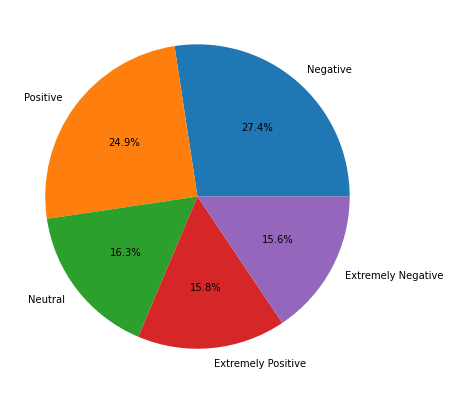

In [4]:
plt.figure(figsize=(10, 7))
plt.pie(sen_bef, labels = sen_bef.index, autopct='%1.1f%%', shadow=False)

In [5]:
#Definimos una funcion para limpiar los textos
def clean(text):
    ps = PorterStemmer()
    rex = re.compile(r'\s+')
    text = text.lower()
    text = ''.join((x for x in text if not x.isdigit()))
    text = re.sub(r"#\S+", "", text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r"http\S+", "", text)
    text = rex.sub(' ', text)
    return text

In [6]:
prue= df.iloc[0][1]
print(prue)
prue= clean(prue)
print(prue)

TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1
trending new yorkers encounter empty supermarket shelves pictured wegmans in brooklyn soldout online grocers foodkick maxdelivery as shoppers stock up 


In [7]:
# Limpiamos los textos 
df['Cleaned Text'] = df['Tweet'].apply(clean)
df.head()

,Idusuario,Tweet,Sentimiento,Cleaned Text
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...


In [8]:
# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}

def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

df['Text tagged'] = df['Cleaned Text'].apply(token_stop_pos)
df.head()

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou..."
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize..."
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]"
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ..."
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin..."


In [10]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos: 
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:  
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew
    
df['Lemma'] = df['Text tagged'].apply(lemmatize)
df.head()

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged,Lemma
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou...",trend new yorkers encounter empty supermarke...
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize...",couldnt find hand sanitizer fred meyer turn ...
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]",find protect love one
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ...",buy hit city anxious shopper stock foodampme...
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin...",one week everyone buying baby milk powder ne...


Análisis de sentimiento con TextBlob

In [9]:
from textblob import TextBlob
# Función para obtener la polaridad
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# Función para realizar la clasificación 
def analysis(score):
    if score <= -0.5:
        return 'Extremely Negative'
    elif score > -0.5 and score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    elif score > 0 and score < 0.5:
        return 'Positive'
    else:
        return 'Extremely Positive'

In [11]:
a= df.iloc[3][5]
print(a)

  buy hit city anxious shopper stock foodampmedical supply worker become st confirm patient staged event


In [94]:
a= df.iloc[0][5]
print(a)

  trend new yorkers encounter empty supermarket shelf picture wegmans brooklyn soldout online grocer foodkick maxdelivery shopper stock


In [12]:
ap= getPolarity(a)
print(ap)

-0.25


In [13]:
analysis(ap)

'Negative'

In [14]:
df['Polarity'] = df['Lemma'].apply(getPolarity) 
df['SentimientoTextBlob'] = df['Polarity'].apply(analysis)
df.head()

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged,Lemma,Polarity,SentimientoTextBlob
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou...",trend new yorkers encounter empty supermarke...,0.018182,Positive
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize...",couldnt find hand sanitizer fred meyer turn ...,0.000000,Neutral
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]",find protect love one,0.500000,Extremely Positive
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ...",buy hit city anxious shopper stock foodampme...,-0.250000,Negative
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin...",one week everyone buying baby milk powder ne...,-0.016667,Negative


In [15]:
sen_Blob= df.SentimientoTextBlob.value_counts()
sen_Blob

Positive              1509
Negative              1036
Neutral                947
Extremely Positive     197
Extremely Negative     109
Name: SentimientoTextBlob, dtype: int64

In [90]:
df

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged,Lemma,Polarity,SentimientoTextBlob
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou...",trend new yorkers encounter empty supermarke...,0.018182,Positive
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize...",couldnt find hand sanitizer fred meyer turn ...,0.000000,Neutral
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]",find protect love one,0.500000,Extremely Positive
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ...",buy hit city anxious shopper stock foodampme...,-0.250000,Negative
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin...",one week everyone buying baby milk powder ne...,-0.016667,Negative
...,...,...,...,...,...,...,...,...
3793,3794,Meanwhile In A Supermarket in Israel -- People...,Positive,meanwhile in a supermarket in israel people da...,"[(meanwhile, r), (supermarket, n), (israel, a)...",meanwhile supermarket israel people dance si...,0.227273,Positive
3794,3795,Did you panic buy a lot of non-perishable item...,Negative,did you panic buy a lot of nonperishable items...,"[(panic, v), (buy, v), (lot, n), (nonperishabl...",panic buy lot nonperishable item echo need f...,0.500000,Extremely Positive
3795,3796,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,asst prof of economics cconces was on nbcphila...,"[(asst, a), (prof, n), (economics, n), (cconce...",asst prof economics cconces nbcphiladelphia ...,0.000000,Neutral
3796,3797,Gov need to do somethings instead of biar je r...,Extremely Negative,gov need to do somethings instead of biar je r...,"[(gov, n), (need, v), (somethings, n), (instea...",gov need somethings instead biar je rakyat a...,-0.700000,Extremely Negative


In [ ]:
#Utilizando Vader

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Funcion para calcular el sentimiento vader  
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
#Funcion para realizar la clasificación
def vader_analysis(compound):
    if compound <= -0.5:
        return 'Extremely Negative'
    elif compound > -0.5 and compound < 0:
        return 'Negative'
    elif compound == 0:
        return 'Neutral'
    elif compound > 0 and compound < 0.5:
        return 'Positive'
    else:
        return 'Extremely Positive'

In [102]:
a= df.iloc[4][5]
print(a)

  one week everyone buying baby milk powder next everyone buy toilet paper


In [103]:
av= vadersentimentanalysis(a)
av

0.0

In [17]:
df['Vader Polarity'] = df['Lemma'].apply(vadersentimentanalysis)
df['SentimientoVader'] = df['Vader Polarity'].apply(vader_analysis)
df.head()

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged,Lemma,Polarity,SentimientoTextBlob,Vader Polarity,SentimientoVader
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou...",trend new yorkers encounter empty supermarke...,0.018182,Positive,-0.2023,Negative
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize...",couldnt find hand sanitizer fred meyer turn ...,0.000000,Neutral,-0.3875,Negative
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]",find protect love one,0.500000,Extremely Positive,0.7783,Extremely Positive
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ...",buy hit city anxious shopper stock foodampme...,-0.250000,Negative,-0.2500,Negative
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin...",one week everyone buying baby milk powder ne...,-0.016667,Negative,0.0000,Neutral


In [18]:
sen_Vader= df.SentimientoVader.value_counts()
sen_Vader

Negative              853
Positive              847
Extremely Positive    834
Extremely Negative    680
Neutral               584
Name: SentimientoVader, dtype: int64

In [ ]:
#Análisis usuando SentiWordnet

In [19]:
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn
def sentiwordnetanalysis(pos_data):
    sentiment = 0
    tokens_count = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1
        # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
    if not tokens_count:
        return 'Neutral'
    if sentiment <= -0.5:
        return 'Extremely Negative'
    elif sentiment > -0.5 and sentiment < 0:
        return 'Negative'
    elif sentiment == 0:
        return 'Neutral'
    elif sentiment > 0 and sentiment < 0.5:
        return 'Positive'
    else:
        return 'Extremely Positive'

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\Blue\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [111]:
a= df.iloc[4][4]
print(a)

[('one', None), ('week', 'n'), ('everyone', 'n'), ('buying', 'n'), ('baby', 'n'), ('milk', 'n'), ('powder', 'v'), ('next', 'a'), ('everyone', 'n'), ('buying', 'v'), ('toilet', 'a'), ('paper', 'n')]


In [112]:
aw= sentiwordnetanalysis(a)
aw

'Neutral'

In [20]:
df['SentimientoSWN'] = df['Text tagged'].apply(sentiwordnetanalysis)
df.head()

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged,Lemma,Polarity,SentimientoTextBlob,Vader Polarity,SentimientoVader,SentimientoSWN
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou...",trend new yorkers encounter empty supermarke...,0.018182,Positive,-0.2023,Negative,Positive
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize...",couldnt find hand sanitizer fred meyer turn ...,0.000000,Neutral,-0.3875,Negative,Extremely Positive
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]",find protect love one,0.500000,Extremely Positive,0.7783,Extremely Positive,Negative
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ...",buy hit city anxious shopper stock foodampme...,-0.250000,Negative,-0.2500,Negative,Positive
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin...",one week everyone buying baby milk powder ne...,-0.016667,Negative,0.0000,Neutral,Neutral


In [21]:
sen_SWN= df.SentimientoSWN.value_counts()
sen_SWN

Extremely Positive    1107
Positive               799
Extremely Negative     749
Negative               590
Neutral                553
Name: SentimientoSWN, dtype: int64

In [22]:
#Datos finales
df

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged,Lemma,Polarity,SentimientoTextBlob,Vader Polarity,SentimientoVader,SentimientoSWN
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou...",trend new yorkers encounter empty supermarke...,0.018182,Positive,-0.2023,Negative,Positive
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize...",couldnt find hand sanitizer fred meyer turn ...,0.000000,Neutral,-0.3875,Negative,Extremely Positive
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]",find protect love one,0.500000,Extremely Positive,0.7783,Extremely Positive,Negative
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ...",buy hit city anxious shopper stock foodampme...,-0.250000,Negative,-0.2500,Negative,Positive
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin...",one week everyone buying baby milk powder ne...,-0.016667,Negative,0.0000,Neutral,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
3793,3794,Meanwhile In A Supermarket in Israel -- People...,Positive,meanwhile in a supermarket in israel people da...,"[(meanwhile, r), (supermarket, n), (israel, a)...",meanwhile supermarket israel people dance si...,0.227273,Positive,0.5574,Extremely Positive,Extremely Positive
3794,3795,Did you panic buy a lot of non-perishable item...,Negative,did you panic buy a lot of nonperishable items...,"[(panic, v), (buy, v), (lot, n), (nonperishabl...",panic buy lot nonperishable item echo need f...,0.500000,Extremely Positive,-0.2500,Negative,Negative
3795,3796,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,asst prof of economics cconces was on nbcphila...,"[(asst, a), (prof, n), (economics, n), (cconce...",asst prof economics cconces nbcphiladelphia ...,0.000000,Neutral,0.0000,Neutral,Neutral
3796,3797,Gov need to do somethings instead of biar je r...,Extremely Negative,gov need to do somethings instead of biar je r...,"[(gov, n), (need, v), (somethings, n), (instea...",gov need somethings instead biar je rakyat a...,-0.700000,Extremely Negative,-0.7650,Extremely Negative,Extremely Negative


([<matplotlib.patches.Wedge at 0x3b89727130>,
 [Text(0.8373617951816905, 0.7133198609110057, 'Negative'),
  Text(-0.5664638995455584, 0.9429308832102381, 'Positive'),
  Text(-1.029235871131516, -0.3881668733626681, 'Extremely Positive'),
  Text(0.04639049516787774, -1.0990213473623154, 'Extremely Negative'),
  Text(0.974131699162296, -0.5109475831112016, 'Neutral')],
 [Text(0.45674279737183116, 0.38908356049691223, '22.5%'),
  Text(-0.3089803088430318, 0.5143259362964935, '22.3%'),
  Text(-0.5614013842535541, -0.21172738547054623, '22.0%'),
  Text(0.025303906455206037, -0.5994661894703538, '17.9%'),
  Text(0.5313445631794341, -0.278698681697019, '15.4%')])

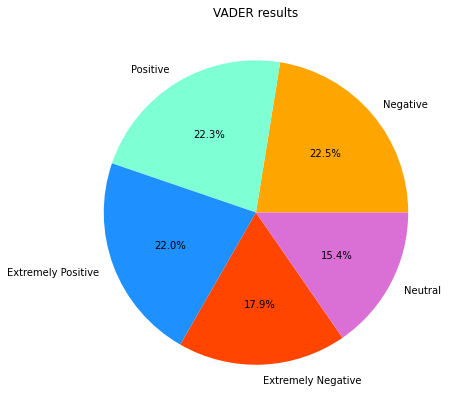

In [147]:
plt.figure(figsize=(15,7))
plt.title("VADER results")
colores = ["Orange","Aquamarine","Dodgerblue","Orangered","Orchid"]
plt.pie(sen_Vader, labels = sen_Vader.index, autopct='%1.1f%%', colors= colores,shadow=False)

([<matplotlib.patches.Wedge at 0x3b89778ca0>,
 [Text(0.6701788608908433, 0.872273061841905, 'Extremely Positive'),
  Text(-0.8761388608331139, 0.6651170547640872, 'Positive'),
  Text(-0.8880968307234465, -0.6490639562161576, 'Extremely Negative'),
  Text(0.18384030210565694, -1.0845288116604836, 'Negative'),
  Text(0.9869118518217423, -0.48580345483927917, 'Neutral')],
 [Text(0.36555210594046, 0.47578530645922085, '29.1%'),
  Text(-0.47789392409078935, 0.36279112078041115, '21.0%'),
  Text(-0.48441645312187986, -0.35403488520881327, '19.7%'),
  Text(0.10027652842126741, -0.5915611699966274, '15.5%'),
  Text(0.5383155555391321, -0.2649837026396068, '14.6%')])

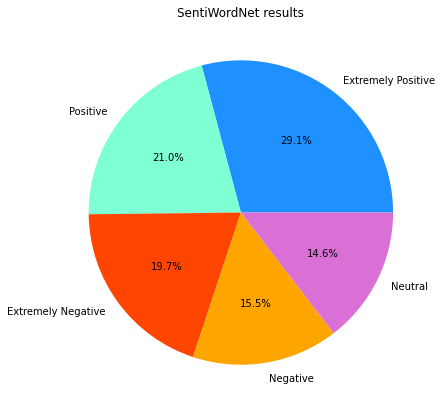

In [148]:
plt.figure(figsize=(15,7))
plt.title("SentiWordNet results")
colores = ["Dodgerblue","Aquamarine","Orangered","Orange","Orchid"]
plt.pie(sen_SWN, labels = sen_SWN.index, autopct='%1.1f%%', colors= colores, shadow=False)

([<matplotlib.patches.Wedge at 0x3b897dd7f0>,
 [Text(0.34873312442622484, 1.0432570191127033, 'Positive'),
  Text(-1.0754297922665315, -0.23119420820073597, 'Negative'),
  Text(0.30529956768075056, -1.0567838823401627, 'Neutral'),
  Text(1.0358229158466128, -0.37023085636805225, 'Extremely Positive'),
  Text(1.095532012147554, -0.09904347711955433, 'Extremely Negative')],
 [Text(0.1902180678688499, 0.5690492831523836, '39.7%'),
  Text(-0.5865980685090171, -0.12610593174585596, '27.3%'),
  Text(0.16652703691677304, -0.5764275721855432, '24.9%'),
  Text(0.5649943177345159, -0.20194410347348302, '5.2%'),
  Text(0.5975629157168476, -0.054023714792484176, '2.9%')])

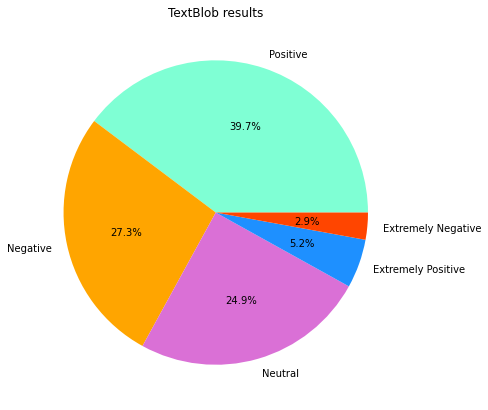

In [149]:
plt.figure(figsize=(15,7))
colores = ["Aquamarine","Orange","Orchid","Dodgerblue","Orangered"]
plt.title("TextBlob results")
plt.pie(sen_Blob, labels = sen_Blob.index, autopct='%1.1f%%',colors= colores, shadow=False)

([<matplotlib.patches.Wedge at 0x3b890263a0>,
 [Text(0.716776929332184, 0.8344044784018874, 'Negative'),
  Text(-0.8848645623268316, 0.653463622811664, 'Positive'),
  Text(-0.8694938694526417, -0.6737806846328207, 'Neutral'),
  Text(0.10538503528793892, -1.0949401784286483, 'Extremely Positive'),
  Text(0.970729275642409, -0.5173825213618685, 'Extremely Negative')],
 [Text(0.39096923418119117, 0.4551297154919385, '27.4%'),
  Text(-0.4826533976328172, 0.3564347033518167, '24.9%'),
  Text(-0.47426938333780455, -0.3675167370724476, '16.3%'),
  Text(0.057482746520693954, -0.5972400973247172, '15.8%'),
  Text(0.5294886958049503, -0.28220864801556456, '15.6%')])

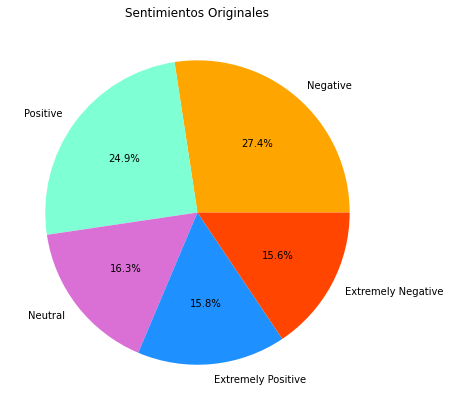

In [151]:
plt.figure(figsize=(15, 7))
plt.title("Sentimientos Originales")
colores = ["Orange","Aquamarine","Orchid","Dodgerblue","Orangered"]
plt.pie(sen_bef, labels = sen_bef.index, autopct='%1.1f%%',colors= colores, shadow=False)

In [155]:
Info= [[599, 947, 619, 1041, 592],[197, 1509, 947, 1036, 109], [834, 847, 584, 853, 680], [1107, 799, 553, 590, 749]]
columnas= ["Extremely Positive", "Positive", "Neutral", "Negative","Extremely Negative"]
Filas= ["Original", "Text Blob", "Vader", "SWN"]
Sentimientos= pd.DataFrame(Info, columns= columnas, index= Filas)
Sentimientos

,Extremely Positive,Positive,Neutral,Negative,Extremely Negative
Original,599,947,619,1041,592
Text Blob,197,1509,947,1036,109
Vader,834,847,584,853,680
SWN,1107,799,553,590,749


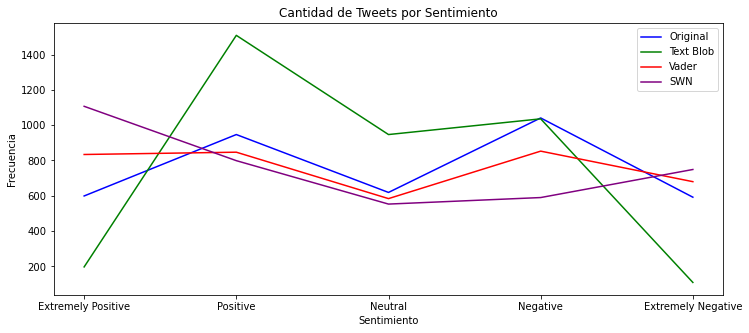

In [171]:
fig= plt.figure(figsize=(12,5))
plt.plot( columnas , Info[0], c= "blue", linestyle='-', label= "Original")
plt.plot( columnas , Info[1], c= "Green", linestyle='-', label= "Text Blob")
plt.plot( columnas , Info[2], c= "Red", linestyle='-', label= "Vader")
plt.plot( columnas , Info[3], c= "Purple", linestyle='-', label= "SWN")
plt.xlabel("Sentimiento")
plt.ylabel("Frecuencia")
plt.title("Cantidad de Tweets por Sentimiento")
plt.legend(loc = "upper right")
plt.show()

In [172]:
df

,Idusuario,Tweet,Sentimiento,Cleaned Text,Text tagged,Lemma,Polarity,SentimientoTextBlob,Vader Polarity,SentimientoVader,SentimientoSWN
0,1,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,"[(trending, v), (new, a), (yorkers, n), (encou...",trend new yorkers encounter empty supermarke...,0.018182,Positive,-0.2023,Negative,Positive
1,2,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,"[(couldnt, v), (find, v), (hand, n), (sanitize...",couldnt find hand sanitizer fred meyer turn ...,0.000000,Neutral,-0.3875,Negative,Extremely Positive
2,3,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,"[(find, v), (protect, v), (loved, v), (ones, n)]",find protect love one,0.500000,Extremely Positive,0.7783,Extremely Positive,Negative
3,4,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits city as anxious shoppers stock up...,"[(buying, v), (hits, n), (city, n), (anxious, ...",buy hit city anxious shopper stock foodampme...,-0.250000,Negative,-0.2500,Negative,Positive
4,5,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,one week everyone buying baby milk powder the...,"[(one, None), (week, n), (everyone, n), (buyin...",one week everyone buying baby milk powder ne...,-0.016667,Negative,0.0000,Neutral,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
3793,3794,Meanwhile In A Supermarket in Israel -- People...,Positive,meanwhile in a supermarket in israel people da...,"[(meanwhile, r), (supermarket, n), (israel, a)...",meanwhile supermarket israel people dance si...,0.227273,Positive,0.5574,Extremely Positive,Extremely Positive
3794,3795,Did you panic buy a lot of non-perishable item...,Negative,did you panic buy a lot of nonperishable items...,"[(panic, v), (buy, v), (lot, n), (nonperishabl...",panic buy lot nonperishable item echo need f...,0.500000,Extremely Positive,-0.2500,Negative,Negative
3795,3796,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,asst prof of economics cconces was on nbcphila...,"[(asst, a), (prof, n), (economics, n), (cconce...",asst prof economics cconces nbcphiladelphia ...,0.000000,Neutral,0.0000,Neutral,Neutral
3796,3797,Gov need to do somethings instead of biar je r...,Extremely Negative,gov need to do somethings instead of biar je r...,"[(gov, n), (need, v), (somethings, n), (instea...",gov need somethings instead biar je rakyat a...,-0.700000,Extremely Negative,-0.7650,Extremely Negative,Extremely Negative


In [ ]:
fin_data = pd.DataFrame(df[['Tweet', 'Lemma', 'Sentimiento','SentimientoTextBlob','SentimientoVader','SentimientoSWN']])

In [25]:
#Todos aquellos cliente con más de 3 movimiento son los clientes de interes
DatosEP= df[df["Sentimiento"].isin(sen_bef[sen_bef == 599].index)]
DatosP= df[df["Sentimiento"].isin(sen_bef[sen_bef== 947].index)]
DatosN= df[df["Sentimiento"].isin(sen_bef[sen_bef== 619].index)]
DatosNg= df[df["Sentimiento"].isin(sen_bef[sen_bef== 1041].index)]
DatosENg= df[df["Sentimiento"].isin(sen_bef[sen_bef== 592].index)]

([<matplotlib.patches.Wedge at 0x29a7c19910>,
 [Text(-0.20929211307437542, 1.0799059271088676, 'Extremely Positive'),
  Text(-0.6215800095241107, -0.9075452009459399, 'Positive'),
  Text(0.3212104443795034, -1.052056961585979, 'Extremely Negative'),
  Text(0.8504258902654837, -0.6976932027518684, 'Negative'),
  Text(1.0770689939040163, -0.2234331720461175, 'Neutral')],
 [Text(-0.11415933440420477, 0.5890395966048368, '56.1%'),
  Text(-0.33904364155860583, -0.49502465506142174, '18.7%'),
  Text(0.17520569693427457, -0.5738492517741703, '9.8%'),
  Text(0.46386866741753646, -0.38055992877374634, '8.8%'),
  Text(0.5874921784930998, -0.12187263929788225, '6.5%')])

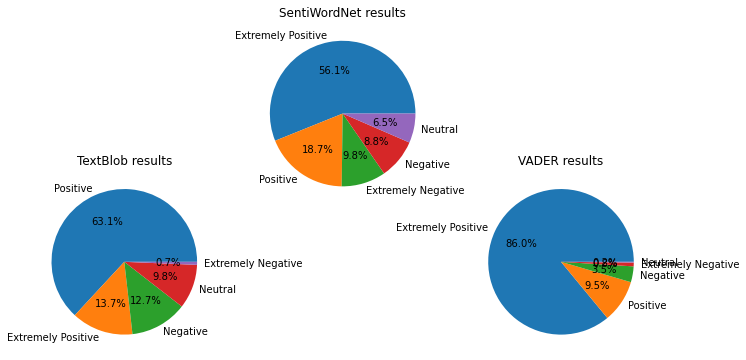

In [39]:
Blob_EP= DatosEP.SentimientoTextBlob.value_counts()
Vader_EP= DatosEP.SentimientoVader.value_counts()
SWN_EP= DatosEP.SentimientoSWN.value_counts()

plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.title("TextBlob results")
plt.pie(Blob_EP, labels = Blob_EP.index, autopct='%1.1f%%', shadow=False)
plt.subplot(1,4,3)
plt.title("VADER results")
plt.pie(Vader_EP, labels = Vader_EP.index, autopct='%1.1f%%', shadow=False)
plt.subplot(2,4,2)
plt.title("SentiWordNet results")
plt.pie(SWN_EP, labels = SWN_EP.index, autopct='%1.1f%%', shadow=False)

([<matplotlib.patches.Wedge at 0x29a7e41a00>,
 [Text(0.42137315799011993, 1.016092841095455, 'Extremely Positive'),
  Text(-1.0988138469067887, 0.051069852612910145, 'Positive'),
  Text(-0.41800007618412327, -1.0174851037288297, 'Negative'),
  Text(0.5040982986970656, -0.9776936663652497, 'Neutral'),
  Text(1.0301511375443388, -0.3857312974287994, 'Extremely Negative')],
 [Text(0.2298399043582472, 0.554232458779339, '37.5%'),
  Text(-0.5993530074037029, 0.02785628324340553, '23.5%'),
  Text(-0.22800004155497627, -0.5549918747611797, '15.5%'),
  Text(0.2749627083802175, -0.5332874543810452, '12.0%'),
  Text(0.5619006204787301, -0.21039888950661786, '11.4%')])

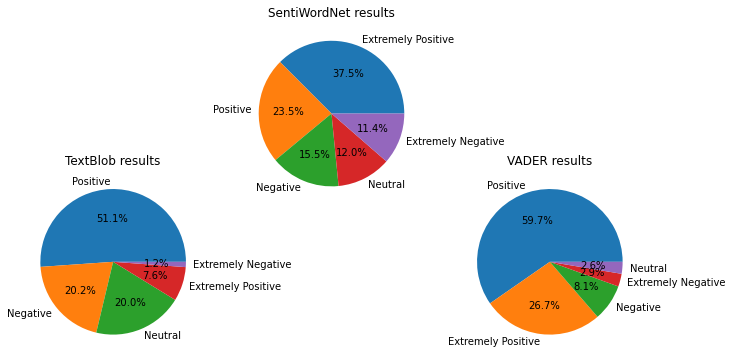

In [40]:
Blob_P= DatosP.SentimientoTextBlob.value_counts()
Vader_P= DatosP.SentimientoVader.value_counts()
SWN_P= DatosP.SentimientoSWN.value_counts()

plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.title("TextBlob results")
plt.pie(Blob_P, labels = Blob_P.index, autopct='%1.1f%%', shadow=False)
plt.subplot(1,4,3)
plt.title("VADER results")
plt.pie(Vader_P, labels = Vader_P.index, autopct='%1.1f%%', shadow=False)
plt.subplot(2,4,2)
plt.title("SentiWordNet results")
plt.pie(SWN_P, labels = SWN_P.index, autopct='%1.1f%%', shadow=False)

([<matplotlib.patches.Wedge at 0x29a80ca880>,
 [Text(0.48766466116212764, 0.9859934980787791, 'Neutral'),
  Text(-1.0864134802243681, 0.1723535609924458, 'Positive'),
  Text(-0.4776312927010515, -0.9908927026841617, 'Extremely Positive'),
  Text(0.5755813106932733, -0.9373932764750416, 'Negative'),
  Text(1.0604440025880275, -0.29233288794640194, 'Extremely Negative')],
 [Text(0.26599890608843324, 0.5378146353156976, '35.4%'),
  Text(-0.5925891710314735, 0.0940110332686068, '24.2%'),
  Text(-0.260526159655119, -0.5404869287368155, '16.5%'),
  Text(0.31395344219633087, -0.5113054235318408, '15.3%'),
  Text(0.5784240014116513, -0.15945430251621923, '8.6%')])

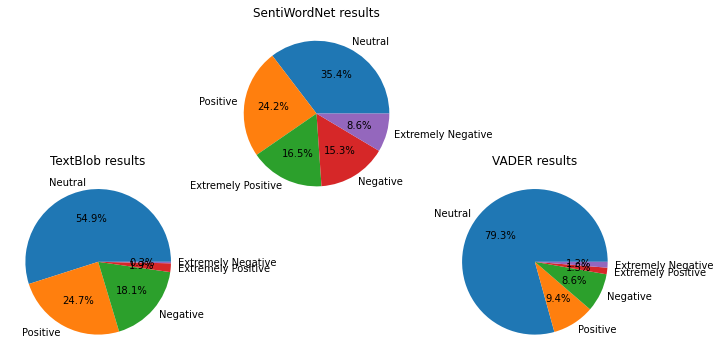

In [41]:
Blob_N= DatosN.SentimientoTextBlob.value_counts()
Vader_N= DatosN.SentimientoVader.value_counts()
SWN_N = DatosN.SentimientoSWN.value_counts()

plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.title("TextBlob results")
plt.pie(Blob_N, labels = Blob_N.index, autopct='%1.1f%%', shadow=False)
plt.subplot(1,4,3)
plt.title("VADER results")
plt.pie(Vader_N, labels = Vader_N.index, autopct='%1.1f%%', shadow=False)
plt.subplot(2,4,2)
plt.title("SentiWordNet results")
plt.pie(SWN_N, labels = SWN_N.index, autopct='%1.1f%%', shadow=False)

([<matplotlib.patches.Wedge at 0x29a81e4640>,
 [Text(0.7689653199412194, 0.7865699820916752, 'Extremely Negative'),
  Text(-0.7325833055781642, 0.8205618199673749, 'Extremely Positive'),
  Text(-0.9648315622532444, -0.5282992111294167, 'Positive'),
  Text(0.1833801529144117, -1.084606711908555, 'Negative'),
  Text(1.0125769573127334, -0.4297533077467663, 'Neutral')],
 [Text(0.41943562905884696, 0.4290381720500046, '25.4%'),
  Text(-0.39959089395172587, 0.447579174527659, '22.5%'),
  Text(-0.5262717612290423, -0.28816320607059087, '20.3%'),
  Text(0.10002553795331547, -0.5916036610410299, '19.1%'),
  Text(0.5523147039887637, -0.23441089513459976, '12.8%')])

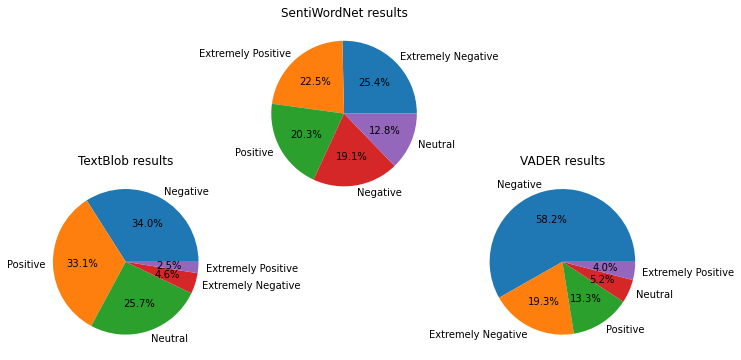

In [42]:
Blob_Ng= DatosNg.SentimientoTextBlob.value_counts()
Vader_Ng= DatosNg.SentimientoVader.value_counts()
SWN_Ng = DatosNg.SentimientoSWN.value_counts()

plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.title("TextBlob results")
plt.pie(Blob_Ng, labels = Blob_Ng.index, autopct='%1.1f%%', shadow=False)
plt.subplot(1,4,3)
plt.title("VADER results")
plt.pie(Vader_Ng, labels = Vader_Ng.index, autopct='%1.1f%%', shadow=False)
plt.subplot(2,4,2)
plt.title("SentiWordNet results")
plt.pie(SWN_Ng, labels = SWN_Ng.index, autopct='%1.1f%%', shadow=False)

([<matplotlib.patches.Wedge at 0x29a8406430>,
 [Text(0.18014482870504098, 1.085148764313369, 'Extremely Negative'),
  Text(-1.0740657962098974, -0.23745034304460266, 'Positive'),
  Text(-0.3221050590501591, -1.0517834049528894, 'Negative'),
  Text(0.6540964480572605, -0.8843968773344214, 'Extremely Positive'),
  Text(1.0645062188319798, -0.2771759550683309, 'Neutral')],
 [Text(0.09826081565729507, 0.5918993259891103, '44.8%'),
  Text(-0.5858540706599439, -0.12951836893341961, '17.4%'),
  Text(-0.17569366857281407, -0.5737000390652124, '16.2%'),
  Text(0.3567798807585057, -0.48239829672786616, '13.5%'),
  Text(0.5806397557265344, -0.15118688458272594, '8.1%')])

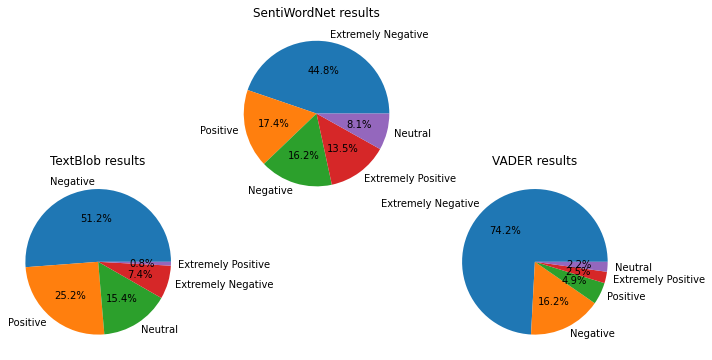

In [43]:
Blob_ENg= DatosENg.SentimientoTextBlob.value_counts()
Vader_ENg= DatosENg.SentimientoVader.value_counts()
SWN_ENg = DatosENg.SentimientoSWN.value_counts()

plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.title("TextBlob results")
plt.pie(Blob_ENg, labels = Blob_ENg.index, autopct='%1.1f%%', shadow=False)
plt.subplot(1,4,3)
plt.title("VADER results")
plt.pie(Vader_ENg, labels = Vader_ENg.index, autopct='%1.1f%%', shadow=False)
plt.subplot(2,4,2)
plt.title("SentiWordNet results")
plt.pie(SWN_ENg, labels = SWN_ENg.index, autopct='%1.1f%%', shadow=False)